## Hegic Greeks Data Analyzer

**Attribution**: A significant portion of this code was adopted from mazzi888's Github Repo: https://github.com/mazzi888/HegicGreeks

### Critical Assumption
In traditional option markets (including crypto), it's common to take the USD denominated market price of the option and use this value in addition to the strike, spot, interest rate, and time to maturity to reverse engineer the "implied volatility" (IV). The IV is a key parameter in solving the option greek exposures.  

When looking at the data, we can see the original premium option buyers paid in ETH or BTC at the time of purchase. Unfortunately, the query we called does not include the *current* price of the option. This analysis is  limited by the fact that we are not able to easily refresh our quotes to align with current market conditions. 

As an initial approach, we can find the spot price of ETH or BTC and then multiply it by the premium paid to calculate the current USD price of the original option. I believe this approach is still flawed as it does not accurately reflect the current value of the option, however, once a better method is determined this function can be adjusted accordingly.

In [1]:
import hegic_greeks as hg
import matplotlib.pyplot as plt

1. Use the GraphQL query below to pull the relevant data for all "ACTIVE" Hegic contracts.

In [2]:
query = """{ 
            options(first: 1000, where: { status: "ACTIVE" }) {
            id
            account
            symbol
            status
            strike
            amount
            lockedAmount
            timestamp
            period
            expiration
            type
            premium
            settlementFee
            totalFee
            }
            }"""

2. Define the `hg` class object and be certain to specify the asset you wish to analyze. Currently, Hegic only has "Bitcoin" and "Ethereum" liquidity pools.

In [3]:
load_data = hg.GetData(query, asset='Ethereum')

3. Load the cleaned and formatted dataframe.

In [4]:
load_data.format_data()

,account,amount,expiration,id,lockedAmount,period,premium,settlementFee,status,strike,symbol,timestamp,totalFee,type,time_to_expiry,premium_usd
0,0x9fd31424cfceab50218906bc1b3d87fe7778ca61,1.0,1605855569,ETH-245,1,2419200,0.082709,0.01,ACTIVE,400.000000,ETH,1603436369,0.092708766500652773,p,0.002760,39.131172
1,0x4c8475548d821e2e4d7f2e3bd2d83a32fff8131a,88.0,1605966126,ETH-258,88,2419200,3.501632,0.88,ACTIVE,888.000000,ETH,1603546926,4.381632353603603603,c,0.006266,18.826049
2,0xe09f694da87b33632bca61e825eb9e3f54e15170,5.0,1605974837,ETH-260,5,2419200,0.412270,0.05,ACTIVE,430.000000,ETH,1603555637,0.462270279069767441,c,0.006542,39.010663
3,0xe09f694da87b33632bca61e825eb9e3f54e15170,5.0,1605975342,ETH-261,5,2419200,0.427625,0.05,ACTIVE,413.371022,ETH,1603556142,0.477625,p,0.006558,40.463588
4,0xa2c12dbe82f19ef06850d4693f2b2d5724b8ea3e,45.0,1605981761,ETH-262,45,2419200,3.848625,0.45,ACTIVE,413.960000,ETH,1603562561,4.298625,c,0.006761,40.463588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0x8024b668a9edfbdb8adc213359c01d2f62818237,5.0,1608165793,ETH-920,5,2419200,0.466500,0.05,ACTIVE,475.433379,ETH,1605746593,0.5165,c,0.076017,44.142096
308,0xe28e120834378746dd68a4f0b0ed6a4876352197,1.0,1606352055,ETH-921,1,604800,0.046620,0.01,ACTIVE,477.580000,ETH,1605747255,0.05662,c,0.018503,22.056854
309,0x04ada96a5c5a1fdf7e315f14aeb2ce9eb61efb5e,10.0,1605838778,ETH-922,10,86400,0.175800,0.1,ACTIVE,479.610000,ETH,1605752378,0.2758,p,0.002227,8.317450
310,0x04ada96a5c5a1fdf7e315f14aeb2ce9eb61efb5e,10.0,1606357297,ETH-923,10,604800,0.465821,0.1,ACTIVE,480.000000,ETH,1605752497,0.5658212125,c,0.018670,22.038933


4. We can now calculate the greeks for each individual option by calling the `get_greeks` method.

In [5]:
df = load_data.get_greeks()
# A subset of some key columns
df[['type', 'strike', 'symbol', 'time_to_expiry', 'iv', 'delta', 'gamma', 'theta', 'vega']]

,type,strike,symbol,time_to_expiry,iv,delta,gamma,theta,vega
0,p,400.000000,ETH,0.002760,7.684613,0.268383,-0.001726,39.131255,-0.081935
1,c,888.000000,ETH,0.006266,6.647528,-0.175286,-0.001037,12.896226,-0.096637
2,c,430.000000,ETH,0.006542,NaN,-1.000000,-0.000000,-0.000000,-0.000000
3,p,413.371022,ETH,0.006558,4.649307,0.292250,-0.001929,14.270560,-0.131623
4,c,413.960000,ETH,0.006761,NaN,-1.000000,-0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...
307,c,475.433379,ETH,0.076017,0.870246,-0.539685,-0.003497,0.819620,-0.517821
308,c,477.580000,ETH,0.018503,0.939620,-0.496209,-0.006597,1.857313,-0.256736
309,p,479.610000,ETH,0.002227,0.481535,0.721777,-0.031210,1.827456,-0.074928
310,c,480.000000,ETH,0.018670,0.975835,-0.483405,-0.006319,1.917532,-0.257675


In [6]:
# Around 9% of all options currently have IV values and greeks which are not solvable using the `py_vollib` library
nan_iv_amount = df[df.iv.isna()].amount.sum()
total_amount = df.amount.sum()
nan_iv_amount/total_amount

0.08847123613084393

5. Calculate total LP greek exposure. As mentioned at the beginning, we can't really comment much on these results given the option prices we used to compute these greeks are likely outdated and need to be refreshed for a more accurate summary.

In [7]:
df[['delta', 'gamma', 'theta', 'vega']].multiply(df.amount, axis=0).sum()

delta     -5372.013812
gamma       -66.607261
theta    108846.042513
vega      -3788.901399
dtype: float64

7. Visualizations of Total LP Theta and Gamma Exposures

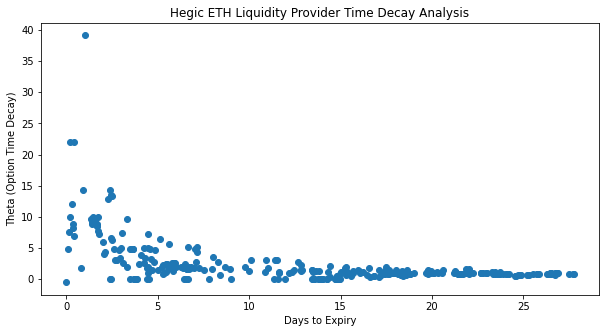

In [8]:
# Note how options with fewer days to expiry have higher theta decay
plt.figure(figsize=(10, 5))
plt.scatter(df.time_to_expiry*365, df.theta)
plt.ylabel("Theta (Option Time Decay)")
plt.xlabel("Days to Expiry");
plt.title("Hegic ETH Liquidity Provider Time Decay Analysis");

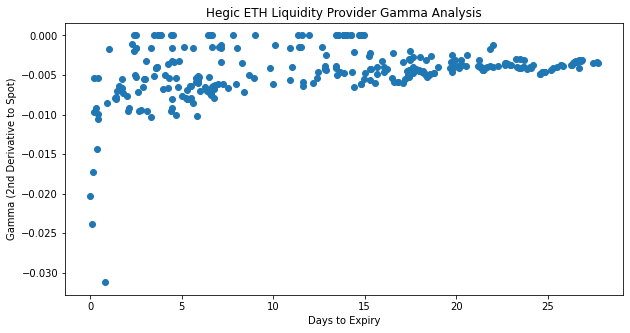

In [9]:
# Similarly, note how gamma risk exposure increases for options close to expiry
plt.figure(figsize=(10, 5))
plt.scatter(df.time_to_expiry*365, df.gamma)
plt.ylabel("Gamma (2nd Derivative to Spot)")
plt.xlabel("Days to Expiry");
plt.title("Hegic ETH Liquidity Provider Gamma Analysis");